## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import time
import datetime as dt
import urllib.request, json
import os
from pandas_datareader import data
import tweepy
from textblob import TextBlob
import re

Using TensorFlow backend.


## Getting data using Alpha Vantage API

In [2]:
data_source = 'alphavantage'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7TONQ8CM5PXZ4YEO'

    # TCS stock market prices
    ticker = "TCS"

    # JSON file with all the stock market data for TCS
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [3]:
df = pd.read_csv("stock_market_data-TCS.csv")

In [4]:
df = df[['Date', 'Open', 'Close', 'Low', 'High']]

In [5]:
df = df.sort_values('Date')

In [6]:
df.head()

,Date,Open,Close,Low,High
26,2013-11-01,35.00,36.20,32.100,37.00
352,2013-11-04,36.80,35.35,34.690,36.80
354,2013-11-05,35.11,35.35,34.821,35.50
735,2013-11-06,35.61,35.90,35.610,36.49
870,2013-11-07,36.80,35.31,34.120,36.80


In [7]:
df.tail()

,Date,Open,Close,Low,High
276,2018-09-27,10.82,10.93,10.7310,10.97
320,2018-09-28,10.89,11.10,10.8400,11.21
1109,2018-10-01,11.10,10.44,10.3500,11.13
700,2018-10-02,10.41,10.26,10.1301,10.46
236,2018-10-03,10.29,10.37,10.1700,10.41


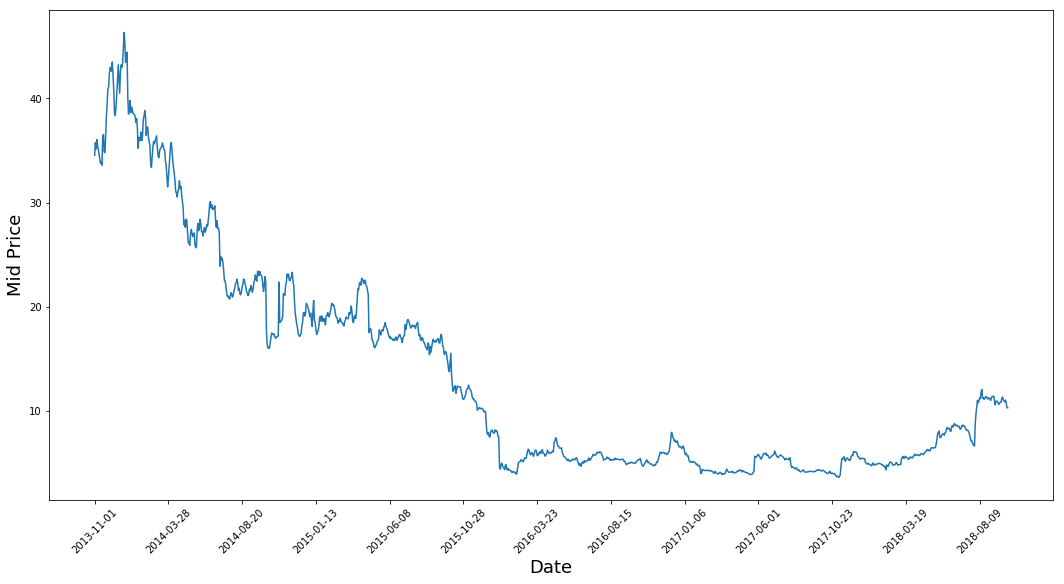

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [9]:
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
df["Mid Prices"] = (high_prices+low_prices)/2.0

In [10]:
df.head()

,Date,Open,Close,Low,High,Mid Prices
26,2013-11-01,35.00,36.20,32.100,37.00,34.5500
352,2013-11-04,36.80,35.35,34.690,36.80,35.7450
354,2013-11-05,35.11,35.35,34.821,35.50,35.1605
735,2013-11-06,35.61,35.90,35.610,36.49,36.0500
870,2013-11-07,36.80,35.31,34.120,36.80,35.4600


## Data Cleaning

In [11]:
df.drop("Date", axis = 1,inplace = True)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
scaler.fit(df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
df = scaler.transform(df)

## Building Long-Short Term Memory Cell to implement Recurrent Neural Network

![title](img/RNN.png)

![title](img/LSTM.png)

In [15]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=50,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print ('compilation time : ', time.time() - start)
    return model

## Load data as per model requirements

In [16]:
def load_data(stock, seq_len):
    amount_of_features = 5
    data = stock
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result =  np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [17]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1110, 5, 5)
y_train (1110,)
X_test (123, 5, 5)
y_test (123,)


In [18]:
model = build_model([5,window,1])

compilation time :  0.058284759521484375


## Training Time!

In [19]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=10,
    validation_split=0.1,
    verbose=1)

Train on 999 samples, validate on 111 samples
Epoch 1/10
999/999 [==============================] - 3s 3ms/step - loss: 0.9814 - val_loss: 0.3039
Epoch 2/10
999/999 [==============================] - 0s 301us/step - loss: 0.3987 - val_loss: 0.1300
Epoch 3/10
999/999 [==============================] - 0s 301us/step - loss: 0.1136 - val_loss: 0.0414
Epoch 4/10
999/999 [==============================] - 0s 262us/step - loss: 0.0424 - val_loss: 0.0141
Epoch 5/10
999/999 [==============================] - 0s 277us/step - loss: 0.0296 - val_loss: 0.0046
Epoch 6/10
999/999 [==============================] - 0s 298us/step - loss: 0.0248 - val_loss: 0.0021
Epoch 7/10
999/999 [==============================] - 0s 301us/step - loss: 0.0252 - val_loss: 0.0016
Epoch 8/10
999/999 [==============================] - 0s 288us/step - loss: 0.0237 - val_loss: 0.0013
Epoch 9/10
999/999 [==============================] - 0s 323us/step - loss: 0.0235 - val_loss: 0.0012
Epoch 10/10
999/999 [=================

In [20]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(trainScore)

0.0137708164167


## Predictions

In [21]:
p = model.predict(X_test)

## Visualizations

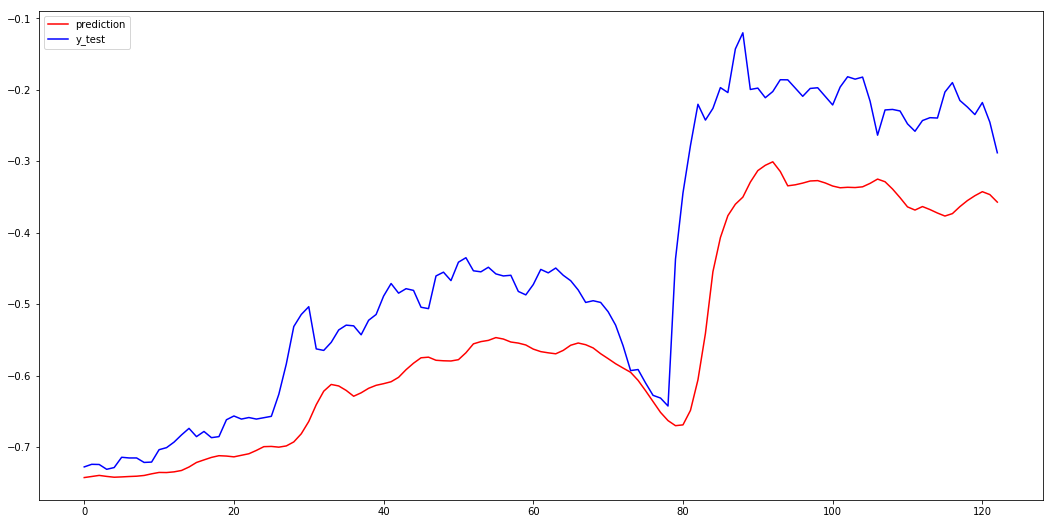

In [22]:
import matplotlib.pyplot as plt2
plt2.figure(figsize = (18,9))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

## Sentiment Analysis

In [23]:
consumer_key= 'E0pFYVai9VaOhqLiRBEC6gpGF'
consumer_secret= 'XAMh4l9XL5nwFK3MN5tAjtXA2YgDN1tw5f7L2n6dz5ib8VYlbm'

access_token='3261604734-86c7DOJP98GwNeFWzvgPQKFUTyHn1ZFwlloJP3v'
access_token_secret='eXEmlEAdxaFjueVP03jsAWeOeNMkI7ToiDQkyvLDa6eX7'

In [24]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [25]:
public_tweets = api.search('TCS', count = 1000)

In [26]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [27]:
def get_tweet_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [28]:
positive = 0
negative = 0
neutral = 0
print(len(public_tweets))
for tweet in public_tweets:
#     print(tweet.text)
    print(clean_tweet(tweet.text))
    sentiment = get_tweet_sentiment(tweet.text) 
    print(sentiment)
    if sentiment == 'positive':
        positive += 1
    elif sentiment == 'negative':
        negative += 1
    elif sentiment == 'neutral':
        neutral += 1
    print("")

100
RT is in full swing Be sure to visit stand 115 to say hello to Keith Sonia and Karina from our King s Hill
positive

TCS Coaches leading our baseline data meeting at Paine painelearns painepride tcslearns
neutral

tcs Por favor ayudemos a expandir sta noticia ella est entre la vida y la muerte porque su m dula se
neutral

RT It s WorldAnimalDay Just RT and FOLLOW for the chance to win an animal themed prize bundle We ve got 3 to giveaway
positive

Our TCSDigitalExplorers are busy grilling panellists from UKI
positive

RT Webinar on Online Filing of Form GSTR 8 on GST Portal by Tax Collectors TCS in Hindi Language will be live today at 4 PM
positive

RT It s WorldAnimalDay Just RT and FOLLOW for the chance to win an animal themed prize bundle We ve got 3 to giveaway
positive

RT Bukhari1 60 TCS 200
neutral

RT It s WorldAnimalDay Just RT and FOLLOW for the chance to win an animal themed prize bundle We ve got 3 to giveaway
positive

RT The webinar on Online Filing of Form GSTR 8 on 

In [29]:
print('Positive:', positive)
print('Negative:', negative)
print('Neutral:', neutral)

Positive: 49
Negative: 5
Neutral: 46
